In [ ]:
!pip install langchain langgraph cassio

In [110]:
# Connection of the AstraDB
import cassio
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:yvPuUcCUlrTZzjGExGcKRRqU:952d9ae22f4037c342d438d2b263316bb2c2c85bd1df1194e5753391a206643c"
ASTRA_DB_ID = "f9cb885b-74ea-44ee-9aa9-d205f467e15e"
cassio.init(
    token=ASTRA_DB_APPLICATION_TOKEN,
    database_id=ASTRA_DB_ID
)


In [ ]:
!pip install langchain_community

In [ ]:
!pip install -U tiktoken langchain_groq langchainhub langchain_huggingface

In [111]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [

    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load the URL

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
print(doc_list)

# Split the text
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=0
)
docs_split = text_splitter.split_documents(doc_list)

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Auton

In [ ]:
docs_split

In [113]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Cassandra
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [114]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(
    embedding=embeddings,
    session=None,
    keyspace=None,
    table_name="MultiAIAgent"
)

In [115]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)
print("Inserted %i headlines." % len(docs_split))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [ ]:
retriver = astra_vector_store.as_retriever()
retriver.invoke("What is LLM?")

In [117]:
# Langgraph Application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import Field, BaseModel


In [118]:
# Data Model

class RouteQuery(BaseModel):
  """ Route a user query to the most relevant data source"""
  datasource: Literal["vectorstore","wiki_search"]=Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore"
      )


In [119]:
from langchain_groq import ChatGroq
from google.colab import userdata
import os
groq_api_key = userdata.get('groq_api_key')

In [120]:
# LLM Integration
llm = ChatGroq(
    groq_api_key = groq_api_key,
    model_name = "Llama-3.1-70b-Versatile"
)

In [121]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [122]:
# Prompt

system = """You are an expert at routing a user question to a vectorstores or wikipedia.
The vectorsote contains documents related to machine learning, deep learning and natural language processing.
Use the vectorstore for question on these topics. Otherwise, use wiki-search.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)
question_router = route_prompt | structured_llm_router


In [124]:
print(question_router.invoke(
    {"question": "What is srk?"
    }
    ))

datasource='wiki_search'


In [ ]:
!pip install wikipedia

In [125]:
# Wiki Agent
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_limit=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [126]:
# Graph
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represents the state of our graph
  Attributes:
  question: question
  generation: LLM generation
  documents: list of documents
  """

  question: str
  generation: str
  documents: List[str]

In [127]:
from langchain.schema import Document

def retrieve(state):
  """
  Retrieve documents from the database.
  Args:
    state(dict): Current Graph State
  Returns:
    state(dict): New key added to the state
  """
  print("...Retrieve...")
  question = state["question"]

  # Retrieval
  documents = retriver.invoke({"question": question})
  return {"documents": documents, "question": question}


In [128]:
def wikiSearch(state):
  """
  Search the wiki for the answer
  Args:
    state(dict): Current Graph State
  Returns:
    state(dict): New key added to the state
  """
  print("...Wiki Search...")
  question = state["question"]
  documents = wiki.invoke({"query": question})
  wiki_results = documents
  wiki_results = Document(page_content=wiki_results)
  return {"documents": wiki_results, "question": question}

In [129]:
def route_question(state):
  """
  Route question to the most relevant data source
  Args:
    state(dict): Current Graph State
  Returns:
    state(dict): New key added to the state
  """
  print("...Route Question...")
  question = state["question"]
  route = question_router.invoke({"question": question})

  if route.datasource == "vectorstore":
    return "vectorstore"
  else:
    return "wiki_search"

In [130]:
from langgraph.graph import END, StateGraph, START
workflow=StateGraph(GraphState)
workflow.add_node("wiki_search", wikiSearch)
workflow.add_node("retrieve", retrieve)

# Build the graph
workflow.add_conditional_edges(
    START,
    route_question,
     {
        "wiki_search":"wiki_search",
        "vectorstore":"retrieve"
    }
)
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

# compile
app = workflow.compile()


In [ ]:
!pip install Ipython

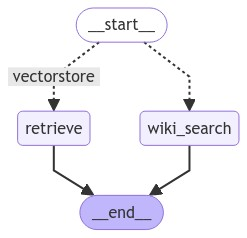

In [131]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [145]:
from pprint import pprint

# Run
inputs = {
    "question": "what is a software?",
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

...Route Question...
...Wiki Search...
"Node 'wiki_search':"
'\n---\n'
Document(page_content='Page: Software suite\nSummary: A software suite (also known as an application suite) is a collection of computer programs (application software, or programming software) of related functionality, sharing a similar user interface and the ability to easily exchange data with each other.\n\n')


In [153]:
from pprint import pprint
inputs = {
    "question": "What is machine learning?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
    pprint("\n---\n")


document = value['documents']
page_content = document.page_content
print(f"Page Content: {page_content}")

# # Final generation
# pprint(value['documents'][0].dict()['metadata']['description'])

...Route Question...
...Retrieve...


AttributeError: 'dict' object has no attribute 'replace'